# 使い方



1.   VLMでラベル付けしたデータを教師データとして使用しています。最初に、VLM_classification.ipynbを実行して、教師データを用意してください。



2. 設定はTraining Configration中のCONFIGに集めてあります。自分の環境に合わせて、修正をお願いします。
    *   CONFIGのDATA_FOLDER, labelded_data_listを環境に合わせて修正ください。

    *   labelded_data_listはVLMの出力ファイルを指定してください。デフォルトでは、"data_list_labeled_by_VLM.csv"となっています。

3. ノートブック全体を実行

**補足**
CONFIG中の以下の部分に試したモデル名を記載しています。
モデルを変えることによって、実行速度、精度が変わります。
もしよければ、コメントアウトする行を変えてお試しください。
'mobilenetv3_small_050.lamb_in1k', 'efficientnet_b0.ra_in1k'は
Colabの無料枠でもそれなりの速度で学習が進みますが、
それ以外はColab無料枠では数時間単位で時間がかかります。,

"model_name":
* "model_name": 'mobilenetv3_small_050.lamb_in1k',
* "model_name": 'efficientnet_b0.ra_in1k',
* "model_name": 'efficientnet_b4.ra2_in1k',
* "model_name": "convnextv2_base.fcmae_ft_in22k_in1k",
* "model_name": 'eva02_small_patch14_224',
* "model_name": "eva02_large_patch14_224",


# ライブラリのインストール

In [1]:
#%pip install torch==2.5.1 torchvision==0.20.1
%pip install torchmetrics
%pip install timm
#%pip install torchvision==0.19.1
%pip install lightning


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [2]:
import torch
torch.__version__

'2.5.1+cu124'

# Google Driveのマウント

In [3]:
# prompt: create code to mount google drive

# # google driveのマウント
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Import Required Libraries 📚</h1></span>

In [4]:
import pandas as pd
from pathlib import Path
import numpy as np

from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision.io import decode_image
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

from torchmetrics.classification import BinaryAccuracy, BinaryAUROC, BinaryF1Score

import timm


import lightning as L
from lightning.pytorch.callbacks import TQDMProgressBar, LearningRateMonitor, RichProgressBar, Callback, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger


In [5]:
def plot(imgs, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            boxes = None
            masks = None
            if isinstance(img, tuple):
                img, target = img
                if isinstance(target, dict):
                    boxes = target.get("boxes")
                    masks = target.get("masks")
                elif isinstance(target, tv_tensors.BoundingBoxes):
                    boxes = target
                else:
                    raise ValueError(f"Unexpected target type: {type(target)}")
            img = F.to_image(img)
            if img.dtype.is_floating_point and img.min() < 0:
                # Poor man's re-normalization for the colors to be OK-ish. This
                # is useful for images coming out of Normalize()
                img -= img.min()
                img /= img.max()

            img = F.to_dtype(img, torch.uint8, scale=True)
            if boxes is not None:
                img = draw_bounding_boxes(img, boxes, colors="yellow", width=3)
            if masks is not None:
                img = draw_segmentation_masks(img, masks.to(torch.bool), colors=["green"] * masks.shape[0], alpha=.65)

            ax = axs[row_idx, col_idx]
            ax.imshow(img.permute(1, 2, 0).numpy(), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Training Configuration ⚙️</h1></span>

In [6]:
now_str = pd.Timestamp.now(tz="Asia/Tokyo").strftime("%Y%m%d_%H%M%S")

In [12]:
CONFIG = {
    "DATA_FOLDER": "/content/drive/MyDrive/82_DX_Quest/topologic_data/",
    "labeled_data_list": "data_list_labeled_by_VLM.csv",
    "exp_name": now_str + '_' + "EFNb0_binary_3folds_50epoch",
    "seed": 42,
    # Model
    "model_name": 'mobilenetv3_small_050.lamb_in1k',
#    "model_name": 'efficientnet_b0.ra_in1k',
#    "model_name": 'efficientnet_b4.ra2_in1k',
#    "model_name": "convnextv2_base.fcmae_ft_in22k_in1k",
#    "model_name": 'eva02_small_patch14_224',
#    "model_name": "eva02_large_patch14_224",
    # Training
    "epochs": 50,
    "epochs_freeze_backbone": -1,
    # Augmentations
    "img_size": 224,
    "train_batch_size": 16,
    "valid_batch_size": 16,
    # Scheduler
    # CosineAnnealingLR
    # "scheduler": 'CosineAnnealingLR',
    # "min_lr": 1e-6,
    # "T_max": 500,
    # OneCycleLR
    "scheduler": 'OneCycleLR',
    "max_lr": 1e-4,
    "pct_start": 0.2,
    "div_factor": 20,
    "final_div_factor": 1e2,
    "weight_decay": 1e-6,
    # CV
    "n_fold": 3,
}
_model = timm.create_model(CONFIG['model_name'], pretrained=True, num_classes=2)
default_cfg = _model.default_cfg
CONFIG['img_size'] = default_cfg['input_size'][-1]
CONFIG['mean'], CONFIG['std'] = default_cfg['mean'], default_cfg['std']
print(f'img size: {CONFIG["img_size"]}, {CONFIG["mean"]}, {CONFIG["std"]}')

model.safetensors:   0%|          | 0.00/6.42M [00:00<?, ?B/s]

img size: 224, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Set Seed for Reproducibility</h1></span>

In [13]:
L.seed_everything(CONFIG['seed'])

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


42

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Read Data 📖 and Create Folds</h1></span>

In [14]:
DATA_FOLDER = Path(CONFIG["DATA_FOLDER"])
df_data = pd.read_csv(str(DATA_FOLDER / CONFIG["labeled_data_list"]))

In [15]:
#df_data['file_path'] = df_data['file_path'].str.replace('/workspace/01_python/82_DX_Quest/地域協働/data/TEG_data', str(DATA_FOLDER))
#df_data.to_csv(str(DATA_FOLDER/'data_list_labeled_by_VLM.csv'), index=False)

In [16]:
#StratifiedKFold
skf = StratifiedKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG['seed'])

df_data["kfold"] = -1
for i, (train_idx, val_idx) in enumerate(skf.split(X=df_data, y=df_data["class_label"])):
#    print(i, val_idx)
    df_data.loc[val_idx, "kfold"] = int(i)

for i in range(CONFIG['n_fold']):
    n_train_data = df_data.query(f'kfold != {i}').groupby('class_label').size()
    n_valid_data = df_data.query(f'kfold == {i}').groupby('class_label').size()
    print(f'*** fold {i} ***')
    print(f'n_train label_0:{n_train_data[0]}, label_1:{n_train_data[1]}')
    print(f'n_valid label_0:{n_valid_data[0]}, label_1:{n_valid_data[1]}')
    print('\n')

*** fold 0 ***
n_train label_0:214, label_1:348
n_valid label_0:107, label_1:174


*** fold 1 ***
n_train label_0:214, label_1:348
n_valid label_0:107, label_1:174


*** fold 2 ***
n_train label_0:214, label_1:348
n_valid label_0:107, label_1:174




In [17]:
df_data.head()

,file_path,class_label,kfold
0,/content/drive/MyDrive/82_DX_Quest/topologic_d...,1,2
1,/content/drive/MyDrive/82_DX_Quest/topologic_d...,1,2
2,/content/drive/MyDrive/82_DX_Quest/topologic_d...,0,1
3,/content/drive/MyDrive/82_DX_Quest/topologic_d...,1,0
4,/content/drive/MyDrive/82_DX_Quest/topologic_d...,0,1


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Dataset Class</h1></span>

In [18]:
class TP_Dataset(Dataset):
    def __init__(self, df, valid_no, stage, transform=None):
        self.valid_no = valid_no
        self.stage = stage
        self.transform = transform
        if stage == "train":
            self.df = df[df.kfold != valid_no].reset_index(drop=True)
        elif stage == "valid":
            self.df = df[df.kfold == valid_no].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
#        file_path = ROOT_DIR / self.datafolder / 'train' / self.df.mode_str[idx] / self.df.file_name[idx]
#        image = Image.open(df.file_path[idx])
        image = decode_image(str(self.df.file_path[idx]))
        if image.shape[0] == 4:
            image = image[:3, :, :]
        label = torch.tensor(self.df.class_label[idx])

        if self.transform:
            image = self.transform(image)

        if self.stage == 'train' or self.stage == "valid":
            return image, label
        elif self.stage == 'predict':
            return image


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Augmentations</h1></span>

In [19]:
size = (CONFIG['img_size'], CONFIG['img_size'])
data_transforms = {
    "train": v2.Compose([
        v2.Resize(size=size),
#        v2.RandomHorizontalFlip(p=0.5),
#        v2.RandomVerticalFlip(p=0.5),
#        v2.RandomRotation(degrees=(-5, 5)),
#        v2.RandomResizedCrop(size=size, scale=(0.95, 1.05)),
        # v2.RandomAffine(degrees=2,
        #                 translate=(0.02, 0.02),
        #                 scale=(0.95, 1.05),
        #                 shear=(-0.02, 0.02, -0.02, 0.02)),

        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=CONFIG['mean'], std=CONFIG['std'])]),
    "valid": v2.Compose([
        v2.Resize(size=(CONFIG['img_size'], CONFIG['img_size'])),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=CONFIG['mean'], std=CONFIG['std'])
    ]),
}

In [20]:
ds = TP_Dataset(df_data, valid_no=0, stage='train', transform=data_transforms['train'])

In [21]:
to_pil = transforms.ToPILImage()
img_org = decode_image(Path(df_data.file_path[0]), mode='RGB')
img, label = ds.__getitem__(0)

label 1


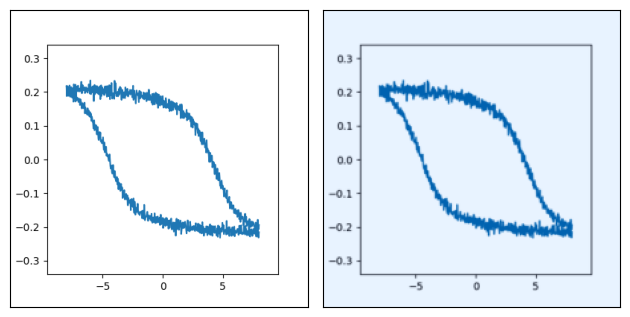

In [22]:
print(f'label {label}')
plot([img_org, img])

In [23]:
def prepare_loaders(df, fold, data_transforms):
    train_dataset = TP_Dataset(df, valid_no=fold, stage='train',
                             transform=data_transforms["train"])
    valid_dataset = TP_Dataset(df, valid_no=fold, stage='valid',
                                 transform=data_transforms["valid"])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'],
                                num_workers=4, shuffle=True, pin_memory=True, drop_last=True,
                             persistent_workers=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'],
                                num_workers=4, shuffle=False, pin_memory=True,
                             persistent_workers=True)
    return train_loader, valid_loader


In [24]:
def make_graph(log_dir):
    df = pd.read_csv(trainer.logger.log_dir + '/metrics.csv')
    df.sort_values(by='step', inplace=True)
    steps_per_epoch = df.loc[:, ['step', 'epoch']].dropna().drop_duplicates().diff().iloc[2]['step']
    df['epoch2'] = df['step'] / steps_per_epoch

    fig, ax = plt.subplots()
    for stage in ['train', 'val']:
        for metric in ['loss', 'auc', 'acc', 'f1']:
            item = stage + '_' + metric
            sns.lineplot(x="epoch2", y=item, data=df, ax=ax, label=item)
    ax2 = ax.twinx()
    ax2.set_yscale('log')
    try:
        y='lr-AdamW'
        sns.lineplot(x="epoch2", y=y, data=df, ax=ax2, label=y)
    except:
        y='lr-Adam'
        sns.lineplot(x="epoch2", y=y, data=df, ax=ax2, label=y)

    fig.savefig(f"{log_dir}/metrics.png")


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Create Model</h1></span>

In [25]:
class TP_Model(L.LightningModule):
    def __init__(self, config:dict =None):
        super().__init__()
        self.save_hyperparameters()
        self.config = config
        self.model = timm.create_model(config['model_name'], pretrained=True, num_classes=2)
        self.loss = nn.BCEWithLogitsLoss()
        self.train_auc = BinaryAUROC()
        self.train_acc = BinaryAccuracy()
        self.train_f1 = BinaryF1Score()
        self.valid_auc = BinaryAUROC()
        self.valid_acc = BinaryAccuracy()
        self.valid_f1 = BinaryF1Score()

        if config['epochs_freeze_backbone'] > 0:
            self.freeze()
        else:
            self.unfreeze()

    def forward(self, x):
        features = self.model(x)
        return features

    def on_train_epoch_start(self):
        # エポックが一定数に達したらbodyを解凍
        if self.current_epoch == self.config['epochs_freeze_backbone']:  # epochs_freeze_backboneで解凍
            print(f'Unfreeze backbone at epoch {self.current_epoch}')
            self.unfreeze()

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits[:, 1], y.to(float))
        preds = logits.argmax(dim=1)
        self.train_auc(preds, y)
        self.train_acc(preds, y)
        self.train_f1(preds, y)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_auc", self.train_auc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_f1", self.train_f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def on_train_epoch_end(self):
        pass

    def on_validation_start(self):
        pass

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits[:, 1], y.to(float))
        preds = logits.argmax(dim=1)
        self.valid_auc(preds, y)
        self.valid_acc(preds, y)
        self.valid_f1(preds, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_auc", self.valid_auc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_acc", self.valid_acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("val_f1", self.valid_f1, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def on_validation_epoch_end(self):
        pass

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits[:, 1], y)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True, on_epoch=True, on_step=False)

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def predict_step(self, batch, batch_idx):
        x = batch
        logits = self(x)
        preds = nn.functional.sigmoid(logits)
        return preds

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(params=self.parameters(), lr=self.config['max_lr'])
#        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.2, mode="max", threshold=0.01, threshold_mode='abs', min_lr=1e-7, verbose=True)
        if self.config['scheduler'] == 'CosineAnnealingLR':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.config['T_max'], eta_min=self.config['min_lr'])
        elif self.config['scheduler'] == 'OneCycleLR':
            scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.config['max_lr'],
                                                            pct_start=self.config['pct_start'],
#                                                            steps_per_epoch=self.config['steps_per_epoch'],
                                                            total_steps=self.trainer.estimated_stepping_batches,
                                                            epochs=self.config['epochs'],
                                                            div_factor=self.config['div_factor'],
                                                            final_div_factor=self.config['final_div_factor'])
        return {"optimizer": optimizer,
                 "lr_scheduler": {
                     "scheduler": scheduler,
                     "interval": "step",
#                     "monitor": "val_loss",
                     "monitor": "val_auc",
                     "frequency": 1}
                 }

    def freeze(self):
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.classifier.parameters():
            param.requires_grad = True

    def unfreeze(self):
        for param in self.model.parameters():
            param.requires_grad = True


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Run Training</h1></span>

In [26]:
f1_scores = []
for i in range(CONFIG['n_fold']):
    print('********************************')
    print(f'*** fold: {i}')
    print('********************************')
    train_loader, valid_loader = prepare_loaders(df_data, fold=i,
                                                     data_transforms=data_transforms)

    model = TP_Model(config=CONFIG)

    trainer = L.Trainer(
        max_epochs=CONFIG['epochs'],
        accelerator="gpu",
#        accelerator="cpu",
        devices=1,  # limiting got iPython runs
        precision='16-mixed',
        num_sanity_val_steps=0,
        logger = CSVLogger(save_dir="./logs", name=CONFIG['exp_name'] , version=f'fold-{i}'),
        log_every_n_steps=5,
        callbacks=[LearningRateMonitor(logging_interval="step"),
                                       #"epoch"),
#                 RichProgressBar(refresh_rate=10),
                  TQDMProgressBar(refresh_rate=10),
                 ModelCheckpoint(monitor='val_f1', mode='max', save_top_k=1, save_last=False,
                                 filename='best_{epoch:02d}_{val_f1:.3f}')
        ]
    )
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
    metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
#        pauc = model.valid_pauc.compute()
    f1 = metrics['val_f1'].max()
    print(f'best f1: {f1}')
    f1_scores.append(f1)
#    make_graph(log_dir=trainer.logger.log_dir)
print(f'Mean f1: {np.mean(f1_scores)}')

********************************
*** fold: 0
********************************


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VI

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


best f1: 0.8774929046630859
********************************
*** fold: 1
********************************


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VI

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: No negative samples in targets, false positive value should be meaningless. Returning zero tensor in false positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)


best f1: 0.939481258392334
********************************
*** fold: 2
********************************


INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: Loading `train_dataloader` to estimate number of stepping batches.
INFO:lightning.pytorch.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO: 
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | MobileNetV3       | 570 K  | train
1 | loss      | BCEWithLogitsLoss | 0      | train
2 | train_auc | BinaryAUROC       | 0      | train
3 | train_acc | BinaryAccuracy    | 0  

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=50` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


best f1: 0.8753993511199951
Mean f1: 0.8974578380584717


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Meric Summary</h1></span>

各foldごとにval_f1が最大となったエポックを抽出し、各種metricのfold全体での平均値を算出する。

In [27]:
log_dir = Path(trainer.logger.log_dir).parent

best_f1s = []
for i in range(CONFIG['n_fold']):
    metric_folder = log_dir / f'fold-{i}'
    df = pd.read_csv(str(metric_folder / "metrics.csv"))
    df.set_index('step', inplace=True)
    train_metrics = ['train_loss', 'train_auc', 'train_acc', 'train_f1']
    val_metrics = ['val_loss', 'val_auc', 'val_acc', 'val_f1']
    df_train = df.loc[:, train_metrics].dropna()
    df_val = df.loc[:, val_metrics].dropna()
    metrics = pd.concat([df_train, df_val], axis=1)
    best_f1_metrics = metrics.iloc[metrics.val_f1.argmax()]
    best_f1s.append(best_f1_metrics)

best_f1s = pd.concat(best_f1s, axis=1).T.reset_index(drop=True)
# 列平均を計算してSeriesに格納
column_means = best_f1s.mean()

# 列平均を表す行をDataFrameに追加
best_f1s.loc['mean'] = column_means
best_f1s.to_csv(str(log_dir / 'metrics_at_best_f1.csv'))


In [28]:
best_f1s

,train_loss,train_auc,train_acc,train_f1,val_loss,val_auc,val_acc,val_f1
0,0.050922,0.887534,0.908929,0.930041,0.242648,0.835052,0.846975,0.877493
1,0.080758,0.941184,0.933929,0.944528,0.258418,0.921662,0.925267,0.939481
2,0.143102,0.831527,0.803571,0.818482,0.253960,0.884332,0.861210,0.875399
mean,0.091594,0.886748,0.882143,0.897684,0.251675,0.880349,0.877817,0.897458


# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#fe346e; border-radius: 100px 100px; text-align:center">Inference</h1></span>

In [29]:
df_data['label_infer'] = None
for i in range(3):
    ds = TP_Dataset(df_data, valid_no=i, stage='valid', transform=data_transforms['valid'])
    dl = DataLoader(ds, batch_size=CONFIG['valid_batch_size'],
                    num_workers=4, shuffle=False, pin_memory=True)

    metric_folder = log_dir / f'fold-{i}'
    ckpt_folder = log_dir / f'fold-{i}' / 'checkpoints'
    ckpt_file = list(ckpt_folder.glob('*.ckpt'))[0]
    model = TP_Model.load_from_checkpoint(ckpt_file)
    # disable randomness, dropout, etc...
    model.eval()
    print(f'fold-{i}, {ckpt_file}')
    preds = []
    with torch.no_grad():
        for j, (images, labels) in enumerate(dl):
#            print(images.shape, labels.shape)
            images = images.to(model.device, dtype=torch.float)
            batch_size = images.size(0)
            _outputs = model.predict_step(images, j)
            _preds = _outputs.argmax(dim=1)
            preds.extend(_preds.detach().cpu().tolist())
    df_data.loc[df_data['kfold']==i , 'label_infer'] = preds


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


fold-0, logs/20250301_142623_EFNb0_binary_3folds_50epoch/fold-0/checkpoints/best_epoch=41_val_f1=0.877.ckpt


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


fold-1, logs/20250301_142623_EFNb0_binary_3folds_50epoch/fold-1/checkpoints/best_epoch=42_val_f1=0.939.ckpt


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


fold-2, logs/20250301_142623_EFNb0_binary_3folds_50epoch/fold-2/checkpoints/best_epoch=17_val_f1=0.875.ckpt


In [30]:
df_data.head()

,file_path,class_label,kfold,label_infer
0,/content/drive/MyDrive/82_DX_Quest/topologic_d...,1,2,1
1,/content/drive/MyDrive/82_DX_Quest/topologic_d...,1,2,1
2,/content/drive/MyDrive/82_DX_Quest/topologic_d...,0,1,1
3,/content/drive/MyDrive/82_DX_Quest/topologic_d...,1,0,1
4,/content/drive/MyDrive/82_DX_Quest/topologic_d...,0,1,0


In [31]:
acc = (df_data['class_label'] == df_data['label_infer']).sum()/len(df_data)
print(f'accuracy = {acc:.3f}')

accuracy = 0.868


In [32]:
# 画像を順次ファイルから読み込んで、nxmに配置して表示する関数
def display_images_in_grid(df, n, m):
    fig, axes = plt.subplots(n, m, figsize=(15, 15))
    axes = axes.flatten()

    for ax, file_path in zip(axes, df['file_path']):
        img = Image.open(file_path)
        ax.imshow(img)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

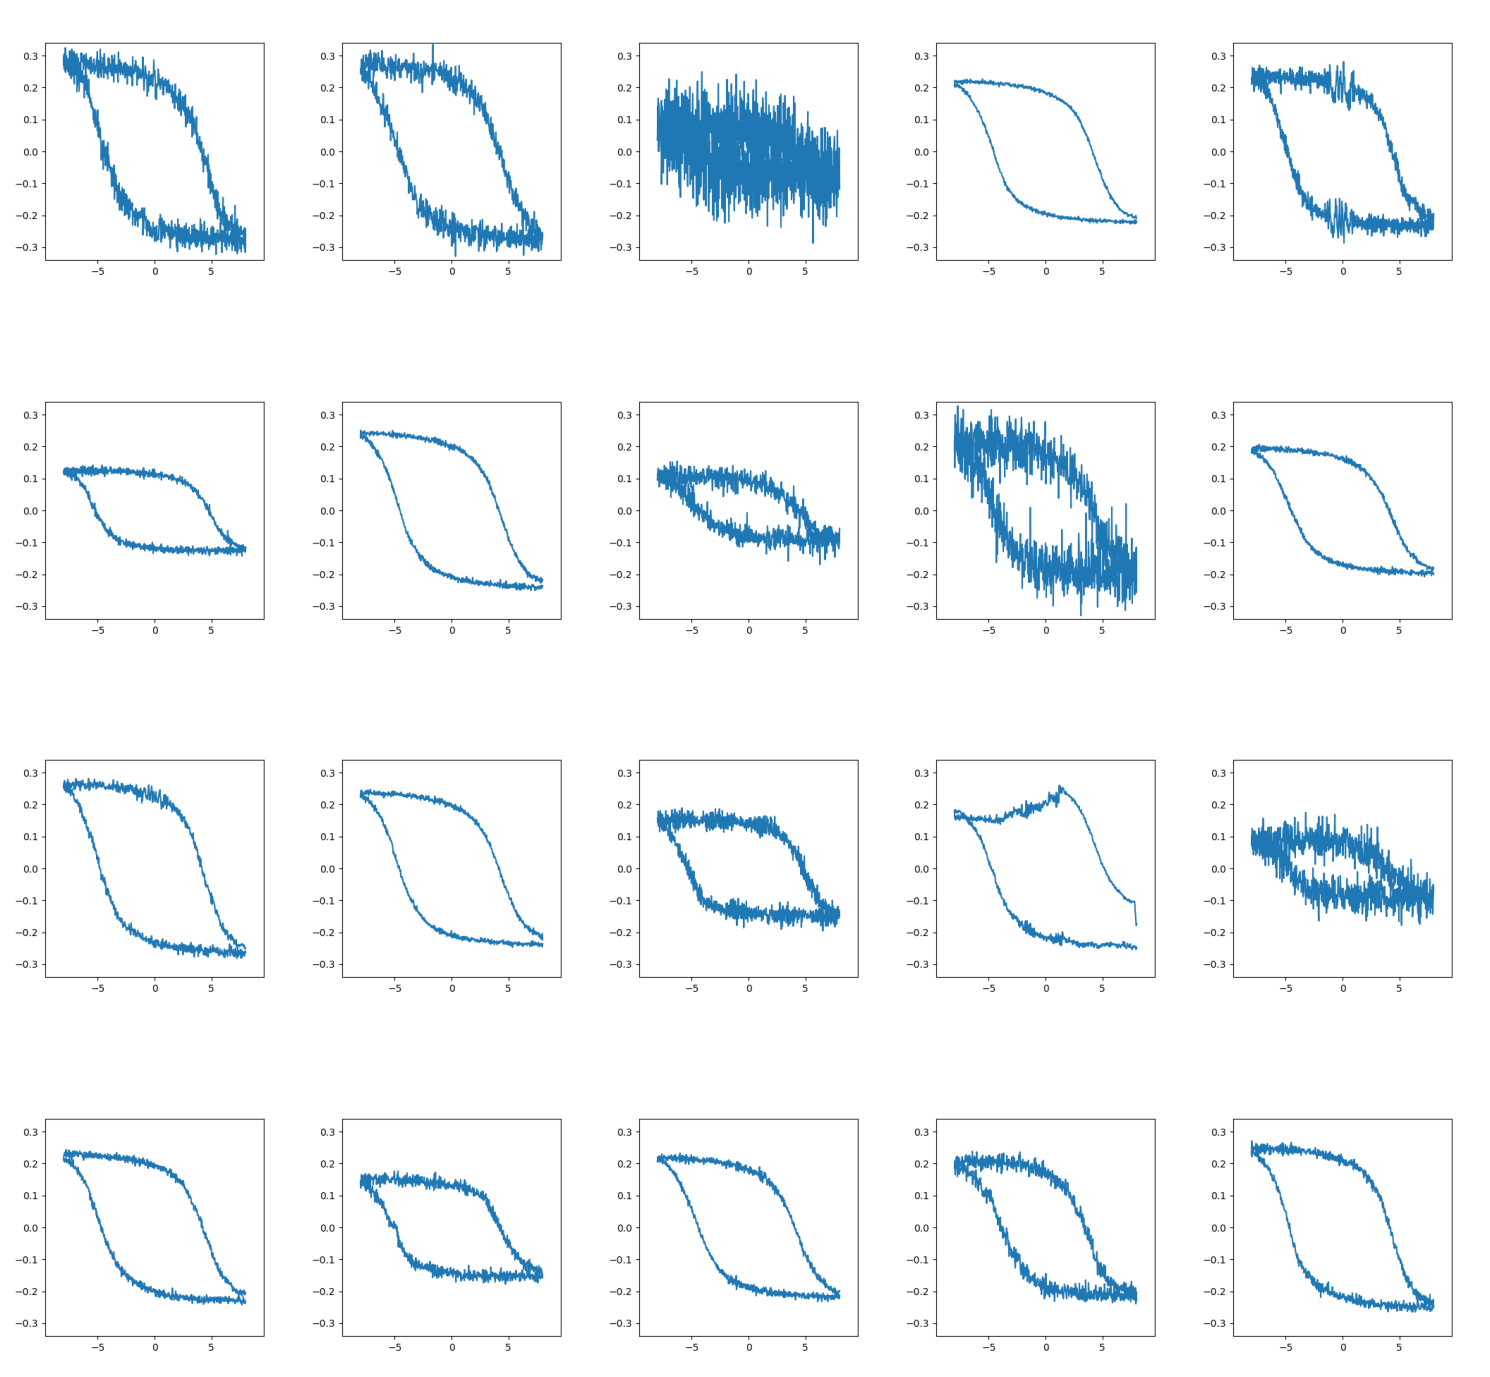

In [33]:
# ランダムに20個のデータを取り出す
random_sample = df_data.query('label_infer == 1').sample(n=20)
display_images_in_grid(random_sample, 4, 5)  # 2行5列に配置して表示

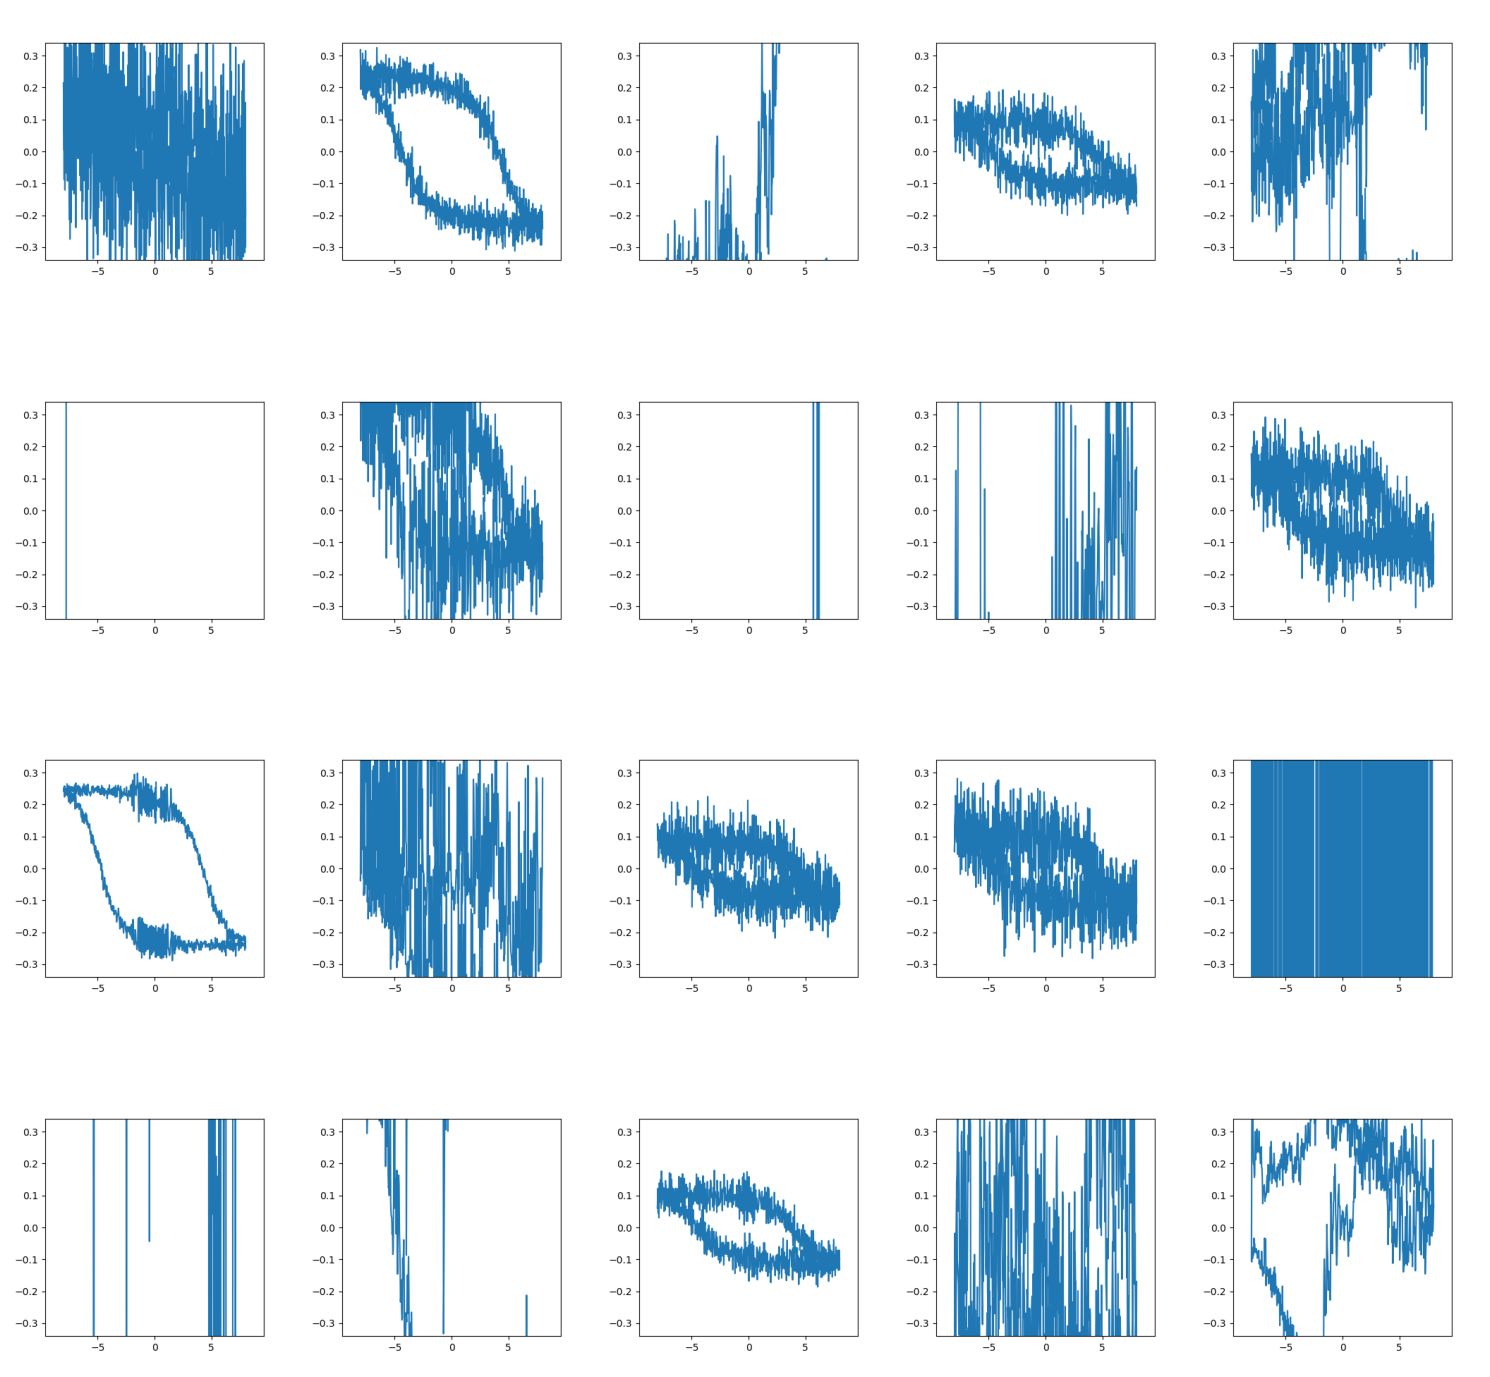

In [34]:
# ランダムに20個のデータを取り出す
random_sample = df_data.query('label_infer == 0').sample(n=20)
display_images_in_grid(random_sample, 4, 5)  # 2行5列に配置して表示